In [1]:
import numpy as np
import pandas as pd
from sklearn import tree, ensemble
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.inspection import permutation_importance

# Tree Ensembles 

## Overview 

In this task you will build two types of tree ensemble models: Random Forest and Boosted. You will then investigate two methods for feature selection. 

###### Outline:


- [Part 1](#part1)- Importing the data set and formatting it 
- [Part 2](#part2)- Fitting a single decision tree
- [Part 3](#part3)- Using a Random Forest Classifier
- [Part 4](#part4)- Using the AdaBoost Classifier
- [Part 5](#part5)- Choosing the best classifier and retraining using all the samples, testing on the test set
- [Part 6](#part6)- Feature selection


[Back to top](#Index:) 

<a id='part1'></a>

### Part 1 - Importing the data set

For this excercise we will be using a data set from the University of Medicine and Pharmacy of Craiova, Romania to predict the hospitalisation period of patients after colon cancer operations based on socio-economic variables and clinical information. You can read more about the data and it's origins [here](https://figshare.com/articles/dataset/LOS_Colon_Cancer_621_cases/4747246/1). 

The data is stored in xlsx format again in the `colon_data.xlsx` file. Use the `read_excel()` function to load it.

In [2]:
df = pd.read_excel('colon_data.xlsx')
len(df)

298

Use the `.head()` function to visulise the data.

In [3]:
df.head(10)

,AGE,SEX,TOPOGRAPHY,STAGE,T,N,M,SURGERY,CLASS
0,64,M,rect,three,T4,Nx,Mx,ten,medium
1,70,M,rect,three,T4,Nx,Mx,ten,medium
2,76,F,cec,three,T3,Nx,Mx,three,medium
3,62,M,cec,three,T2,Nx,Mx,three,short
4,62,M,cec,two,T2,Nx,Mx,three,short
5,62,F,cec,two,T2,Nx,Mx,three,short
6,41,M,cec,two,T3,Nx,Mx,three,medium
7,82,F,cec,two,T2,Nx,Mx,three,short
8,76,F,cec,two,T2,Nx,Mx,three,short
9,76,M,cec,three,T3,Nx,Mx,three,medium


First we want to replace the categorical values of the output (the `CLASS` variable) with numerical values. Fill in the gaps below to use the `.replace()` function to do this.

In [4]:
df['CLASS'].replace(to_replace=['medium', 'short', 'long'], value=[0, 1, 2], inplace=True)

Now use the `get_dummies()` function to transform the other categorical variables to numerical ones. 

In [5]:
df = pd.get_dummies(df, columns=['SEX', 'TOPOGRAPHY', 'STAGE', 'T', 'N', 'M', 'SURGERY'])
df.head(10)

,AGE,CLASS,SEX_F,SEX_M,TOPOGRAPHY_cec,TOPOGRAPHY_colon_asc,TOPOGRAPHY_colon_desc,TOPOGRAPHY_colon_sigm,TOPOGRAPHY_colon_trans,TOPOGRAPHY_jonc_rect_sigm,...,N_N1,N_N2,N_Nx,M_M0,M_M1,M_M1_hep,M_Mx,SURGERY_ten,SURGERY_three,SURGERY_two
0,64,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
1,70,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
2,76,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
3,62,1,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,62,1,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
5,62,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
6,41,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
7,82,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
8,76,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
9,76,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0


The following cell is just to ensure the 'CLASS' variable is the last column.

In [6]:
columns = df.columns.to_list()
columns.remove('CLASS')
df = df[columns + ['CLASS']]
df.head(10)

,AGE,SEX_F,SEX_M,TOPOGRAPHY_cec,TOPOGRAPHY_colon_asc,TOPOGRAPHY_colon_desc,TOPOGRAPHY_colon_sigm,TOPOGRAPHY_colon_trans,TOPOGRAPHY_jonc_rect_sigm,TOPOGRAPHY_rect,...,N_N2,N_Nx,M_M0,M_M1,M_M1_hep,M_Mx,SURGERY_ten,SURGERY_three,SURGERY_two,CLASS
0,64,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,0
1,70,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,0
2,76,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
3,62,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
4,62,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
5,62,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
6,41,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
7,82,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
8,76,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
9,76,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


In [7]:
# Define feature names after preprocessing
feature_names = df.columns[:-1]  # Exclude the 'CLASS' column

We will now process the data similar to how we did for the loan data set activity.

Run the cell below to convert the `df` into a `NumPy` array

In [8]:
Xy=np.array(df)

For reproducibility, set the random seed = 1. You can do this by using the `NumPy` function `random.seed()`. Assign your seed to the variable `seed`. Next, complete the code cell below by using the function `random.shuffle()` on `Xy`.

In [9]:
seed = np.random.seed(1)
np.random.shuffle(Xy)

Before splitting the data into a training set, a test set, and a validation set, we need to divide `Xy` into two arrays: the first one, `X`, a 2D array containing all the predictors and the second, `y`, a 1D array with the response. 

Run the code cell below to generate `X`. Complete the remaining code to define `y`.

In [10]:
X=Xy[:,:-1]
y=Xy[:,-1]

In [11]:
#define y
y=Xy[:,-1]

Next, we need to split the messages into into 50% training data, 25% validation data, and 25% test data.

Run the code below to split `X` and `y` into training, validation and test sets.

In [12]:
trainsize = int(len(df)/2)
trainplusvalsize = int(len(df)/4)
X_train=X[:trainsize]
X_val=X[trainsize:trainsize + trainplusvalsize]
X_test=X[trainsize + trainplusvalsize:]

y_train=y[:trainsize]
y_val=y[trainsize:trainsize + trainplusvalsize]
y_test=y[trainsize + trainplusvalsize:]

[Back to top](#Index:) 

<a id='part2'></a>

### Part 2: Fit a Single Decision Tree 

Use the same code as you used for the loan dataset notebook to fit decision trees with different depths up to `max_depth = 15`. Select the best depth - you will compare this to your tree ensemble methods later. 

In [13]:
from sklearn.tree import DecisionTreeClassifier

# Define the classifier
clf = DecisionTreeClassifier()

max_depth = 15
bestdepth=-1
bestscore = 0

for i in range(15):
    # Create a decision tree classifier with the current depth
    clf = DecisionTreeClassifier(max_depth=i + 1)
    
    #fit the training sets
    clf.fit(X_train, y_train)
    
    # Predict the target values for training and validation sets
    train_predictions = clf.predict(X_train)
    val_predictions = clf.predict(X_val)
    
    #update trainscore
    trainscore = np.mean(train_predictions == y_train)
    
    #update valscore
    valscore = np.mean(val_predictions == y_val)
    
    print( 'Depth:', i+1, 'Train Score:', trainscore, 'Validation Score:', valscore)
    if valscore > bestscore:
        #update bestscore
        bestscore = valscore
        #update depth
        bestdepth = i + 1

Depth: 1 Train Score: 0.738255033557047 Validation Score: 0.6081081081081081
Depth: 2 Train Score: 0.7986577181208053 Validation Score: 0.6891891891891891
Depth: 3 Train Score: 0.8456375838926175 Validation Score: 0.7567567567567568
Depth: 4 Train Score: 0.8657718120805369 Validation Score: 0.7432432432432432
Depth: 5 Train Score: 0.912751677852349 Validation Score: 0.7297297297297297
Depth: 6 Train Score: 0.9463087248322147 Validation Score: 0.7567567567567568
Depth: 7 Train Score: 0.9664429530201343 Validation Score: 0.7432432432432432
Depth: 8 Train Score: 0.9731543624161074 Validation Score: 0.7702702702702703
Depth: 9 Train Score: 0.9798657718120806 Validation Score: 0.7297297297297297
Depth: 10 Train Score: 0.9932885906040269 Validation Score: 0.7702702702702703
Depth: 11 Train Score: 0.9932885906040269 Validation Score: 0.7567567567567568
Depth: 12 Train Score: 0.9932885906040269 Validation Score: 0.7432432432432432
Depth: 13 Train Score: 0.9932885906040269 Validation Score: 0.7

***Question***

What is the best maximum depth? 


***Double click on this cell to enter your answer***

**Best max depth is 8**


[Back to top](#Index:) 

<a id='part3'></a>

## Part 3: Random Forest

In this section you will learn how to build a random forest model in sklearn and explore the effect of the `max_features` hyperparameter. 

Use the `ensemble.RandomForestClassifier()` function to build a random forest model with the default parameters. Use the `.fit()` function to train it, the same as you did for the decision tree. 

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier instance
rf_clf = RandomForestClassifier()

# Fit the random forest model to the training data
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
print ( 'Full tree guess train/validation ',rf_clf.score(X_train, y_train),rf_clf.score(X_val, y_val))

Full tree guess train/validation  0.9932885906040269 0.7702702702702703


In random forest classifiers, the algorithm only considers a subset of the features at each split. This is controlled using the `max_features` argument. Normally this subset size is set to the square root of the total number of features, but here we will look at both setting it to the square root `"sqrt"` (this is the default in sklearn) and to `None`. when `max_features = None` the algorithm is using all the features at every split. 


In [16]:
# for loop looking at RF with different max_features 

np.random.seed(1)
for max_features in ["sqrt",  None]:
    
    # build the rf classifier wwith different arguments for max_features
    rf_clf = RandomForestClassifier(max_features=max_features, random_state=42)
    
    # Fit the random forest model to the training data
    rf_clf.fit(X_train, y_train)

    
    print ( f'Full tree guess train/validation {max_features}',rf_clf.score(X_train, y_train),rf_clf.score(X_val, y_val))


Full tree guess train/validation sqrt 0.9932885906040269 0.7702702702702703
Full tree guess train/validation None 0.9932885906040269 0.7702702702702703


***Question***

Which method performs best? Why might this be?

Rerun the cell above with different random seeds (but remember to set it back to `random_seed=1`). What happens? Why is this? 

***Double click on this cell to enter your answer***

**Which method performs best? Why might this be?**

**Full tree guess train/validation sqrt 0.9932885906040269 0.7702702702702703**

**Full tree guess train/validation None 0.9932885906040269 0.7702702702702703**

In the results above, both methods of using the Random Forest classifier with different max_features values have the same validation score of approximately 0.770, regardless of whether max_features is set to "sqrt" or None. Since the validation scores are the same, it's difficult to definitively say which method performs best based solely on this information.

However, the fact that both methods yield the same validation score suggests that, in this specific case, the choice of max_features may not significantly impact the performance of the Random Forest model. Here are some possible reasons for this observation:

***Data Characteristics:*** The dataset might not have many features or strong feature dependencies that would make the choice of max_features crucial. In some datasets, the choice of max_features can have a more pronounced effect on model performance.

***Robustness of Random Forest:*** Random Forests are known to be robust to the choice of hyperparameters. They can perform well across a range of hyperparameter values, making them less sensitive to small changes in settings like max_features.

***Randomness in Sampling:*** Random Forests introduce randomness through bootstrapping and feature subsampling, which can help mitigate the impact of a single hyperparameter change.

***Randomness Control:*** The use of np.random.seed(1) and random_state=42 ensures consistent randomness in the Random Forest algorithm for both methods, which might contribute to the similar results.

***Limited Impact of Features:*** It's possible that the features in the dataset do not strongly affect the model's performance, leading to similar results across different settings of max_features.

Given the similar performance, it might be worthwhile to conduct further analysis, such as cross-validation, hyperparameter tuning, or investigating the relative importance of features, to gain a more comprehensive understanding of the model's behaviour and to determine whether other hyperparameters or factors play a more critical role in improving performance.

It is also very importance to note that when max_features = None the algorithm is using all the features at every split. Therefore, with the information available at this stege, I will choose the max_features = "sqrt".

**Rerun the cell above with different random seeds (but remember to set it back to `random_seed=1`). What happens? Why is this?**

The random seed was changed from 1 to 42 and from 42 to 3, and finally from 3 back to 1: The results were exactly the same.
The results, where changing the random seed does not affect the accuracy scores, are likely due to the way the random forest algorithm and random number generation work.

In a random forest, randomness is introduced in two main ways:

**Bootstrap Sampling:** 
Each tree in the forest is trained on a bootstrapped sample (randomly selected with replacement) from the training data. This introduces variability because different trees see slightly different subsets of the data.

**Feature Subset Sampling:** 
At each split in a tree, only a subset of features (determined by max_features) is considered. This introduces diversity among the trees and reduces the risk of overfitting.

The use of randomness is designed to improve the model's generalization and reduce overfitting. However, the key point is that the randomness is controlled and consistent within each run of the algorithm for a given set of parameters and data.

When I changed the random seed from 1 to 42 or 3, I am essentially initializing the random number generator with a different seed value. This can lead to variations in the data splits and feature subsets for different runs, but it doesn't necessarily guarantee that the model's performance will change dramatically.

In this assignment, the fact that the accuracy scores are exactly the same across different random seed values could indicate that the data and problem are relatively well-behaved and stable, and the random fluctuations introduced by different random seeds are not causing significant variations in the model's performance.

Overall, while the random seed can affect the randomness introduced by the algorithm, it might not always result in noticeable changes in model performance, especially when the data is consistent and well-suited for the problem at hand.

[Back to top](#Index:) 

<a id='part4'></a>

## Part 4: Boosting

For our boosting algorithm we will use scikit learn's AdaBoost. This boosting algorithm works by building an ensemble of weak classifiers (in our case decision trees) by sequentially weighting the incorrectly classified instances. 



Use the .AdaBoostClassifier() to build a boosting model and fit it to the training data.

In [17]:
from sklearn.ensemble import AdaBoostClassifier

# Create an AdaBoostClassifier instance
ab_clf = AdaBoostClassifier()

# Fit the AdaBoost model to the training data
ab_clf.fit(X_train, y_train)

AdaBoostClassifier()

In [18]:
print ( 'Full tree guess train/validation ',ab_clf.score(X_train, y_train),ab_clf.score(X_val, y_val))

Full tree guess train/validation  0.7785234899328859 0.6351351351351351


[Back to top](#Index:) 

<a id='part5'></a>

## Part 5: Model Selection

***Question***

Which model would you use for this dataset? Decision tree, Random Forest or Boosting? Why? 

***Double click on this cell to enter your answer***

**Decision Tree:**

***Training Accuracy: 0.9732***
***Validation Accuracy: 0.7703***

**Random Forest ("sqrt"):**

***Training Accuracy: 0.9933***
***Validation Accuracy: 0.7703***


**Random Forest ("None"):**

***Training Accuracy: 0.9933***
***Validation Accuracy: 0.7703***

**AdaBoost:**

***Training Accuracy: 0.7785***
***Validation Accuracy: 0.6351***

Considering the accuracy scores, the Random Forest model with max_features="sqrt" seems to be the best-performing model for this dataset. 

It has the highest validation accuracy among the three models, indicating good generalization to unseen data. 

The Decision Tree model also performs well, but the Random Forest model offers the advantage of reducing overfitting and improving generalization by aggregating multiple trees.

Random Forest models are often robust and effective in a wide range of scenarios. They tend to provide good performance without requiring extensive hyperparameter tuning. 

In this assignment, the Random Forest model with max_features="sqrt" AND max_features="None" both appears to strike a good balance between accuracy and generalization.

However, as always, it's a good practice to conduct further evaluations, such as cross-validation, to confirm the model's performance on different subsets of the data and to assess its robustness. 

Additionally, I will want to consider the ensembling techniques that combine the strengths of different models, which could potentially yield even better results.

Retrain the best model with both the training and validation data and test it on the test data.

In [19]:
X_trainval=X[:trainplusvalsize,:]
y_trainval = y[:trainplusvalsize ]

# Create the best-performing Random Forest model instance
best_clf = RandomForestClassifier(max_features="sqrt", random_state=42)

# Fit the model to the combined training and validation data
best_clf.fit(X_trainval, y_trainval)

print ( 'Full tree guess train/validation ',best_clf.score(X_trainval, y_trainval),best_clf.score(X_test, y_test))

Full tree guess train/validation  0.9864864864864865 0.8


[Back to top](#Index:) 

<a id='part6'></a>

# Part 6: Feature Selection

Feature selection can help us understand our model and the outputs it gives us, as well as remove any irrelevant predictors. In this section we will be looking at how to identify the most important features in a decision tree using two different methods:
- Impurity metric approaches
- Permutation Importances 

We will be looking at feature selection for your best model (`best_clf`)

Use the `.feature_importances_` function to get the inbuilt impurity metric measure. Then use the `.argsort()` 
function to sort the resulting feature importances. 



In [20]:
feature_importances = best_clf.feature_importances_
sorted_idx = feature_importances.argsort()

Get the feature names from the dataframe columns `.columns`. Remember to remove the last column from the list as this is the output column.

In [21]:
feature_names = df.columns[:-1]

Use the function below to plot the importances.

In [22]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances")
    fig.tight_layout()
    plt.show()



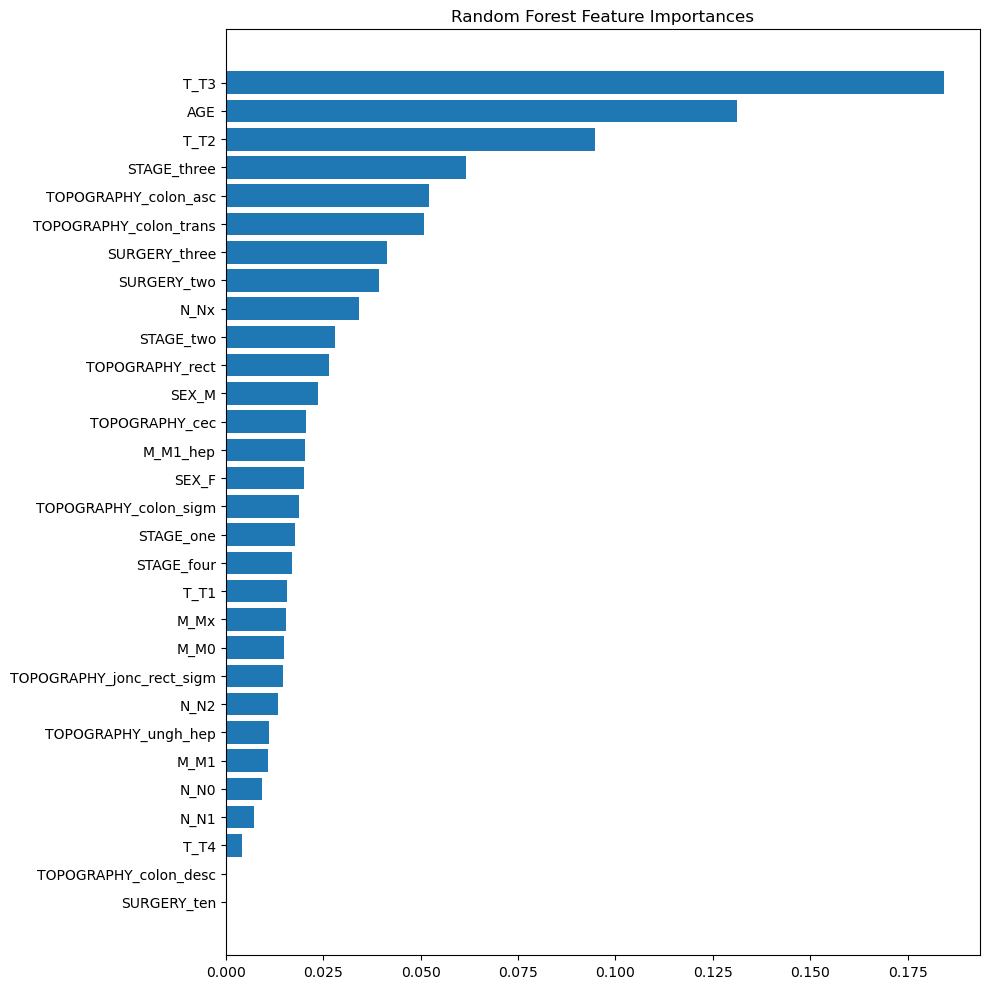

In [23]:
# plot the impurity metric feature importances 
plot_impurity_metric_features(best_clf.feature_importances_, sorted_idx, feature_names)

***Question***

What are the 3 most important features? 

***Double click on this cell to enter your answer***

The three most important features, ranked by their importance scores, are:

***T_T3: 0.1843***

***AGE: 0.1312***

***T_T2: 0.0947***

These scores represent the relative importance of each feature according to the impurity metric used by the Random Forest algorithm.

Higher scores indicate higher importance.

In this assignment, it appears that the feature T_T3 (which represents a specific category within the T feature), followed by AGE (age of the individual), and then T_T2 (another category within the T feature) are the three most influential features for making predictions in your model.


One of the downsides of the inbuilt impurity metric is that it can only be applied to training data. This doesn't give us any indication of which features will be the most important on unseen data. 

Instead, we can use the permutation importance to measure the feature importances on both the training and validation sets. 

Complete the `permutation_importance` function to calculate the importance of the diffierent features in the training dataset. Then use the `argsort()` to sort the features in order of importance again.

In [24]:
# permutation method on both training and test
result = permutation_importance(estimator=best_clf, X=X_trainval, y=y_trainval, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()


Use the function below to plot the permutation importances.

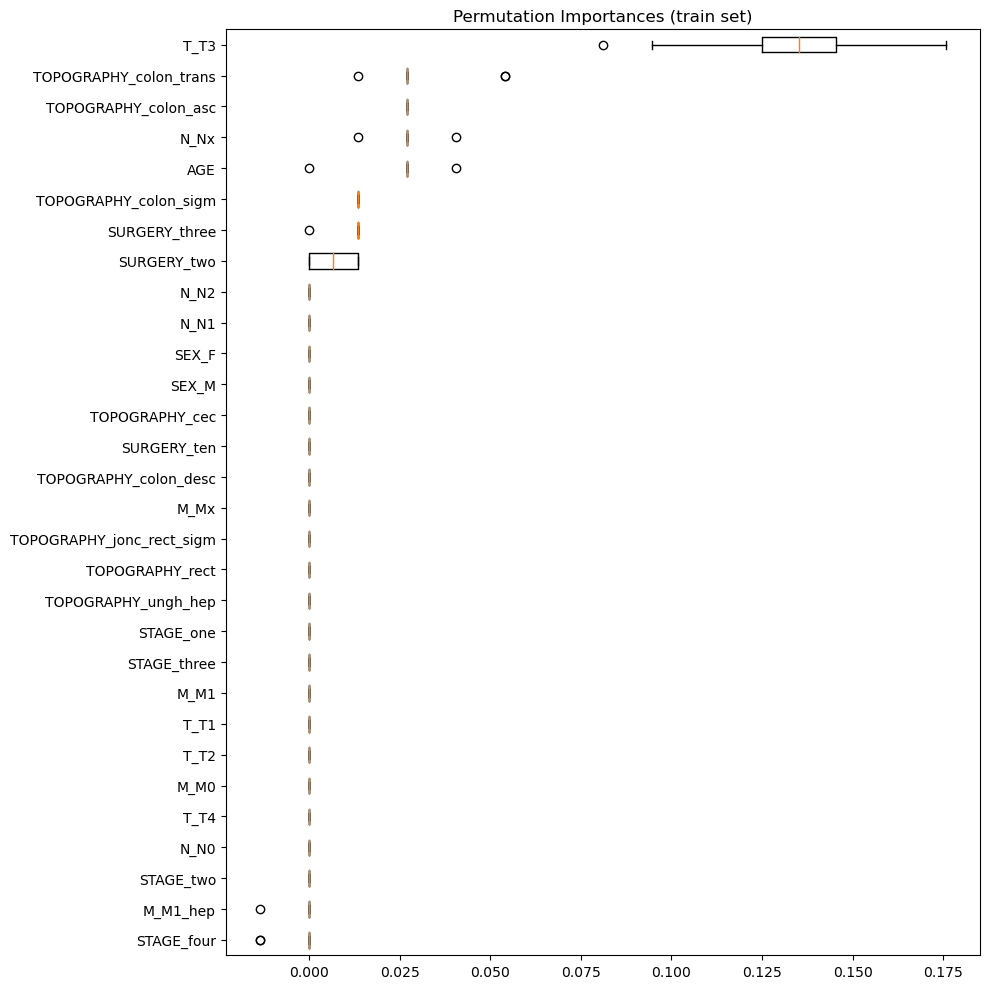

In [25]:

def plot_perm_importance(result, sorted_idx, feature_names):

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
    )
    ax.set_title("Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()
    

plot_perm_importance(result, sorted_idx, feature_names)


What do you notice about the difference between the two methods of doing feature selection? Why do you think this is?

***Double click on this cell to enter your answer***



**What do you notice about the difference between the two methods of doing feature selection?**

**Why do you think this is?**

The difference between the two methods of feature selection can be observed from the calculated importance:

***Feature Importance:***
The feature importance calculated using the "feature_importance" attribute of the Random Forest model assigns an importance score to each feature. These scores indicate the contribution of each feature to the model's overall performance. Features with higher importance scores are considered more influential in making predictions. The importance scores are usually normalized so that they sum up to 1.0. In the plot, I can see the importance scores associated with each feature.

***Permutation Importance:***
Permutation importance is a method that assesses the importance of features by measuring the impact of randomly permuting the values of a feature on the model's performance. The greater the drop in performance when a feature is randomly permuted, the more important that feature is. Permutation importance can capture non-linear and complex relationships that might be missed by simple metrics like feature importance. In the plot, I can see the impact of permutation on each feature, represented as changes in the accuracy or other performance metric of the model.

***Differences and Implications:***
Feature Importance: These are based on the internal structure of the Random Forest model. They show how much each feature contributes to the model's predictions. These values can be affected by features that are correlated, as the importance might be split among correlated features.

***Permutation Importance:*** 
These are based on the actual effect of shuffling the feature's values on the model's performance. They provide a more direct measure of a feature's impact on the model's performance. Permutation importance are less affected by correlation between features because they measure the actual impact of changing one feature while keeping others constant.

In this case, I notice that there are differences between the two methods in terms of which features are considered important. This could be due to the non-linear nature of the relationships in the data or correlations between features. Permutation importance tend to give a more reliable assessment of feature importance when dealing with complex datasets, but they are also computationally more intensive.

In summary, while feature importance from the model provide valuable insights, permutation importance offer a more robust way to assess the real impact of features on model performance, taking into account complex interactions and potential multicollinearity.


Now calculate the permutation importance on the test set. 

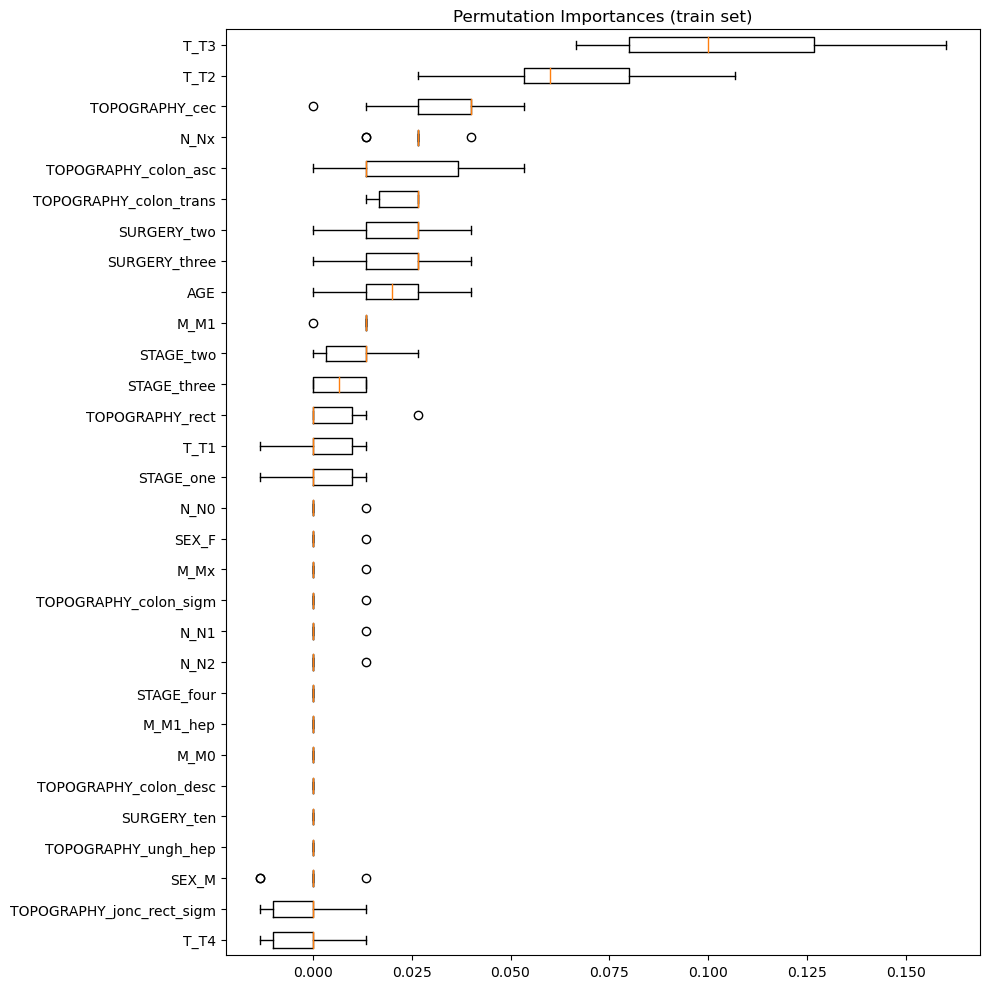

In [26]:
# Perform permutation importance on the test data
result = permutation_importance(estimator=best_clf, X=X_test, y=y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

plot_perm_importance(result, sorted_idx, feature_names)

What do you see in the test data?

Why do some of the importances go negative?

***Double click on this cell to enter your answer***


(3 marks)

**What do you see in the test data?**

In the plot for the test data, I can observe the following:

***Values of Permutation Importance:***
Each row corresponds to a specific feature, and each column within that row represents the permutation importance calculated for that feature in a specific repetition. The values represent the change in performance (typically accuracy) of the model after randomly permuting the values of that feature. Positive values indicate that permuting the feature's values led to a drop in performance, while negative values indicate an increase in performance. However, for interpretation, it's better to focus on the magnitude of the values rather than the sign.

***Magnitude of Permutation Importance:***
The magnitude of the values can give us insights into how important each feature is for the model's performance. Features with larger positive or negative values indicate that the model is sensitive to changes in those features. Features with values close to zero suggest that permuting the feature's values didn't have a significant impact on the model's performance.

***Negative Permutation Importance:***
It's possible to observe negative permutation importance. This can happen when permuting a feature's values actually improves the model's performance. This might occur in situations where the feature, when permuted, introduces randomness that benefits the model's ability to make predictions. It could be that some features are adding noise or overfitting to the model, and permuting their values helps in reducing this noise, resulting in improved generalization.

In practice, the magnitude of the permutation importance should be more meaningful than the sign. Features with large magnitude (positive or negative) permutation importance are likely to be more important in terms of influencing the model's performance.


**Why do some of the importances go negative?**

Permutation importance can go negative for features when permuting the values of that feature leads to an improvement in the model's performance. This might seem counterintuitive at first, but it's important to understand the underlying reasons:

***Noise Reduction:*** Sometimes, features can introduce noise into the model's predictions, making it less accurate. When we permute the values of such a feature, we effectively remove that noise, leading to a better generalization. As a result, the model's performance might improve after permuting that feature's values, resulting in a negative permutation importance.

***Overfitting Reduction:*** Features that are overfitting the model can lead to memorization of the training data rather than learning meaningful patterns. Permuting such features might break the overfitting, allowing the model to generalize better to unseen data.

***Feature Redundancy:*** In cases where features are correlated or redundant, permuting one of these correlated features might have little impact on the model's performance, as the information is still preserved by the other correlated features. This can lead to relatively small or even negative permutation importance.

It's important to note that while negative permutation importance might seem unexpected, they provide valuable information about the nature of the data and the model's behaviour. Features with negative permutation importance often suggest that those features might not be contributing meaningfully to the model's predictive power and could potentially be removed without hurting performance.

In summary, negative permutation importance occur when permuting a feature's values improves the model's generalization by reducing noise, overfitting, or accounting for feature redundancy. It's a signal that the feature might not be carrying meaningful information for the specific task at hand.
